In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 12.0 MB/s eta 0:00:00


## Dependencies

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.14.0


In [ ]:
import os
import shap
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from keras.models import Model
from keras import optimizers, applications
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# direktori dataset
dataset_path = "/content/drive/MyDrive/DFU_Dataset"

## Load data

In [ ]:
train_datagen = ImageDataGenerator(
                rescale=1./255,
                rotation_range=20,
                horizontal_flip=True,
                shear_range=0.2,
                fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(
                rescale=1./255,
                rotation_range=20,
                horizontal_flip=True,
                shear_range=0.2,
                fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
                rescale=1./255,
                rotation_range=20,
                horizontal_flip=True,
                shear_range=0.2,
                fill_mode='nearest'
)

# Model parameters

In [ ]:
labels = ['Abnormal(Ulcer)','Normal(Healthy skin)']

In [ ]:
train_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/DFU_Dataset/train',
                                              target_size = (224,224),
                                              batch_size=2,
                                              class_mode="categorical",
                                              shuffle=True,
                                              seed=4,
                                              interpolation='bilinear'
                                              )

valid_generator = validation_datagen.flow_from_directory('/content/drive/MyDrive/DFU_Dataset/validation',
                                                   target_size=(224,224),
                                                   batch_size=1,
                                                   class_mode='categorical',
                                                   shuffle=True,
                                                   seed=5,
                                                   interpolation='bilinear'
                                                   )

test_generator = test_datagen.flow_from_directory('/content/drive/MyDrive/DFU_Dataset/test',
                                            target_size=(224,224),
                                            batch_size=1,
                                            class_mode='categorical',
                                            shuffle=False,
                                            )

Found 757 images belonging to 2 classes.
Found 85 images belonging to 2 classes.
Found 211 images belonging to 2 classes.


# Model

In [ ]:
import keras
import keras.utils
from keras import utils as np_utils
import numpy as np
from keras import layers
from keras.models import Model, load_model
import pydot
from matplotlib.pyplot import imshow

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from keras.layers import GlobalAveragePooling2D, Flatten, BatchNormalization, Dense, Dropout
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
vgg16 = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
for layer in vgg16.layers:
    layer.trainable = False
x = GlobalAveragePooling2D()(vgg16.output)
x = Dropout(0.4)(x)
x = BatchNormalization()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
prediction = Dense(2, activation='softmax')(x)
model = Model(inputs=vgg16.inputs, outputs=prediction)
model.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
import tensorflow as tf
run_opts = tf.compat.v1.RunOptions(report_tensor_allocations_upon_oom = True)
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= 'accuracy')

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("VGG16.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.4, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [ ]:
history = model.fit(train_generator,
                    epochs=20,
                    validation_data = valid_generator,
                    callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/20
379/379 [==============================] - ETA: 0s - loss: 0.6087 - accuracy: 0.6988
Epoch 1: val_accuracy improved from -inf to 0.88235, saving model to VGG16.h5
379/379 [==============================] - 448s 1s/step - loss: 0.6087 - accuracy: 0.6988 - val_loss: 0.2447 - val_accuracy: 0.8824 - lr: 0.0010
Epoch 2/20


You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


379/379 [==============================] - ETA: 0s - loss: 0.5861 - accuracy: 0.7081
Epoch 2: val_accuracy did not improve from 0.88235
379/379 [==============================] - 17s 45ms/step - loss: 0.5861 - accuracy: 0.7081 - val_loss: 0.3395 - val_accuracy: 0.8824 - lr: 0.0010
Epoch 3/20
379/379 [==============================] - ETA: 0s - loss: 0.5371 - accuracy: 0.7371
Epoch 3: val_accuracy did not improve from 0.88235

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
379/379 [==============================] - 18s 46ms/step - loss: 0.5371 - accuracy: 0.7371 - val_loss: 0.3425 - val_accuracy: 0.8471 - lr: 0.0010
Epoch 4/20
379/379 [==============================] - ETA: 0s - loss: 0.4611 - accuracy: 0.7873
Epoch 4: val_accuracy did not improve from 0.88235
379/379 [==============================] - 17s 46ms/step - loss: 0.4611 - accuracy: 0.7873 - val_loss: 0.3393 - val_accuracy: 0.8588 - lr: 4.0000e-04
Epoch 5/20
379/379 [==============================]

# SHAP Model explainability

#### About SHAP's DeepExplainer from the [source repository](https://github.com/slundberg/shap#deep-learning-example-with-deepexplainer-tensorflowkeras-models):
- Deep SHAP is a high-speed approximation algorithm for SHAP values in deep learning models that builds on a connection with [DeepLIFT](https://arxiv.org/abs/1704.02685) described in the SHAP NIPS paper. The implementation here differs from the original DeepLIFT by using a distribution of background samples instead of a single reference value, and using Shapley equations to linearize components such as max, softmax, products, divisions, etc.

### First let's see the images that we will explain

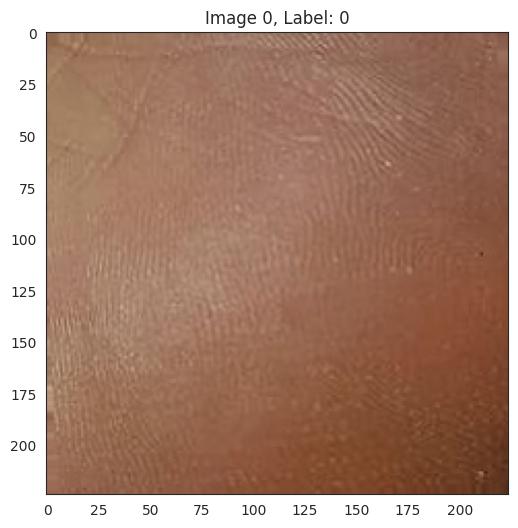

In [ ]:
n_explain = 1
valid_generator.batch_size = 10 # background dataset
background, lbls = next(valid_generator)

sns.set_style("white")
plt.figure(figsize=[6, 6])
for index, image in enumerate(background[:n_explain]):
    plt.subplot(n_explain, 1, index+1)
    plt.imshow(image)
    plt.title("Image %s, Label: %s" % (index, np.argmax(lbls[index])))

plt.show()

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


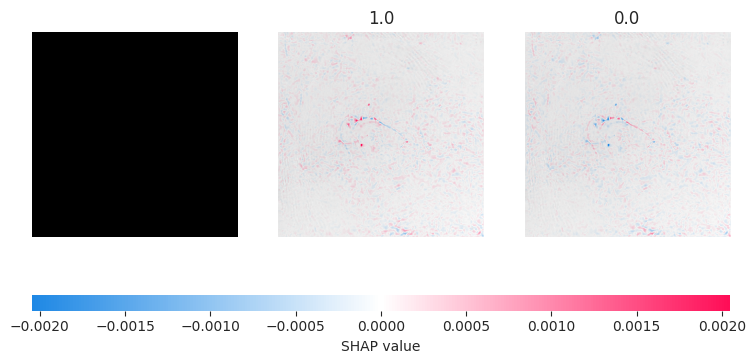

In [ ]:
# explain predictions of the model on "n_explain" images
e = shap.GradientExplainer(model, background)
shap.explainers._deep.deep_tf.op_handlers["AddV2"] = shap.explainers._deep.deep_tf.passthrough
shap_values = e.shap_values(background)

# plot the feature attributions
shap.image_plot(shap_values, -background[:n_explain], labels=lbls, hspace=0.1)

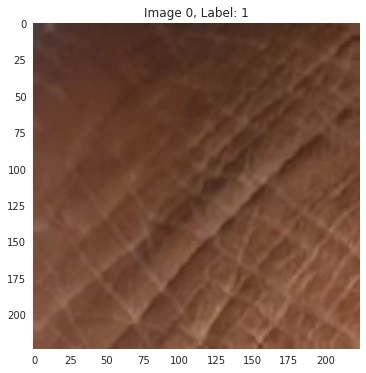

In [ ]:
n_explain = 1
valid_generator.batch_size = 10 # background dataset
background, lbls = next(valid_generator)

sns.set_style("white")
plt.figure(figsize=[6, 6])
for index, image in enumerate(background[:n_explain]):
    plt.subplot(n_explain, 1, index+1)
    plt.imshow(image)
    plt.title("Image %s, Label: %s" % (index, np.argmax(lbls[index])))

plt.show()

### Now the SHAP explanation

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


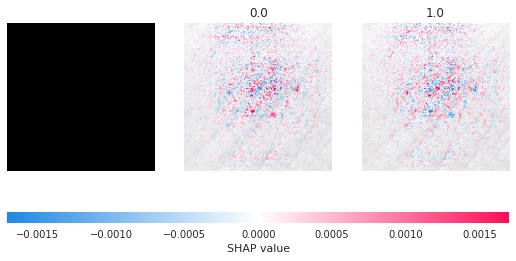

In [ ]:
# explain predictions of the model on "n_explain" images
e = shap.GradientExplainer(model, background)
shap.explainers._deep.deep_tf.op_handlers["AddV2"] = shap.explainers._deep.deep_tf.passthrough
shap_values = e.shap_values(background)

# plot the feature attributions
shap.image_plot(shap_values, -background[:n_explain], labels=lbls, hspace=0.1)

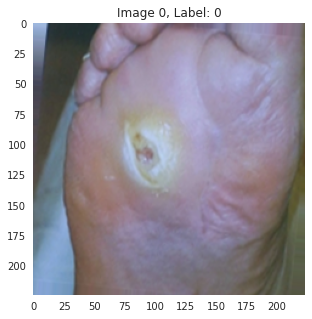

In [ ]:
n_explain = 1
valid_generator.batch_size = 10 # background dataset
background, lbls = next(valid_generator)

sns.set_style("white")
plt.figure(figsize=[5, 5])
for index, image in enumerate(background[:n_explain]):
    plt.subplot(n_explain, 1, index+1)
    plt.imshow(image)
    plt.title("Image %s, Label: %s" % (index, np.argmax(lbls[index])))

plt.show()

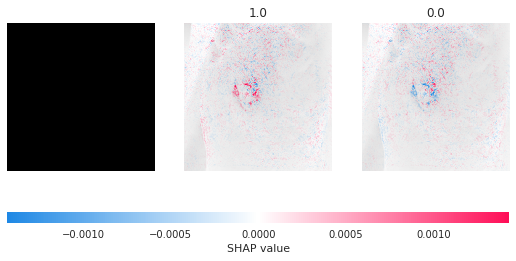

In [ ]:
# explain predictions of the model on "n_explain" images
e = shap.GradientExplainer(model, background)
shap.explainers._deep.deep_tf.op_handlers["AddV2"] = shap.explainers._deep.deep_tf.passthrough
shap_values = e.shap_values(background)

# plot the feature attributions
shap.image_plot(shap_values, -background[:n_explain], labels=lbls, hspace=0.1)

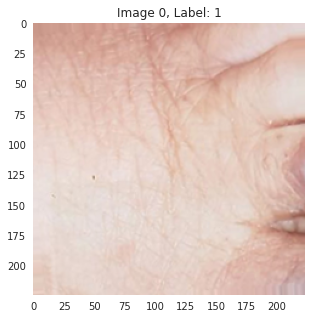

In [ ]:
n_explain = 1
valid_generator.batch_size = 10 # background dataset
background, lbls = next(valid_generator)

sns.set_style("white")
plt.figure(figsize=[5, 5])
for index, image in enumerate(background[:n_explain]):
    plt.subplot(n_explain, 1, index+1)
    plt.imshow(image)
    plt.title("Image %s, Label: %s" % (index, np.argmax(lbls[index])))

plt.show()

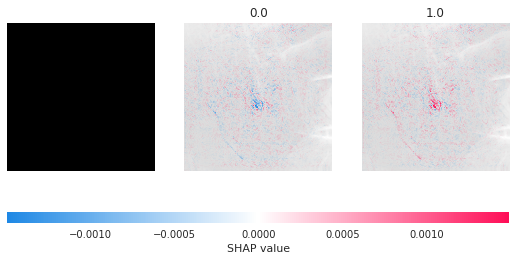

In [ ]:
# explain predictions of the model on "n_explain" images
e = shap.GradientExplainer(model, background)
shap.explainers._deep.deep_tf.op_handlers["AddV2"] = shap.explainers._deep.deep_tf.passthrough
shap_values = e.shap_values(background)

# plot the feature attributions
shap.image_plot(shap_values, -background[:n_explain], labels=lbls, hspace=0.1)

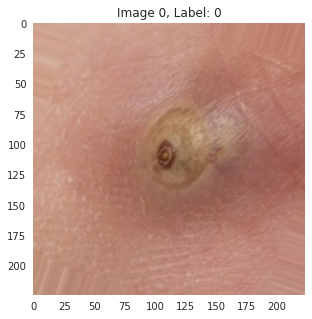

In [ ]:
n_explain = 1
valid_generator.batch_size = 10 # background dataset
background, lbls = next(valid_generator)

sns.set_style("white")
plt.figure(figsize=[5, 5])
for index, image in enumerate(background[:n_explain]):
    plt.subplot(n_explain, 1, index+1)
    plt.imshow(image)
    plt.title("Image %s, Label: %s" % (index, np.argmax(lbls[index])))

plt.show()

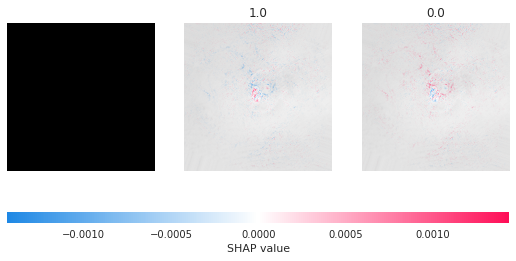

In [ ]:
# explain predictions of the model on "n_explain" images
e = shap.GradientExplainer(model, background)
shap.explainers._deep.deep_tf.op_handlers["AddV2"] = shap.explainers._deep.deep_tf.passthrough
shap_values = e.shap_values(background)

# plot the feature attributions
shap.image_plot(shap_values, -background[:n_explain], labels=lbls, hspace=0.1)

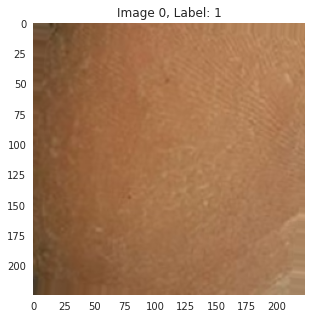

In [ ]:
n_explain = 1
valid_generator.batch_size = 10 # background dataset
background, lbls = next(valid_generator)

sns.set_style("white")
plt.figure(figsize=[5, 5])
for index, image in enumerate(background[:n_explain]):
    plt.subplot(n_explain, 1, index+1)
    plt.imshow(image)
    plt.title("Image %s, Label: %s" % (index, np.argmax(lbls[index])))

plt.show()

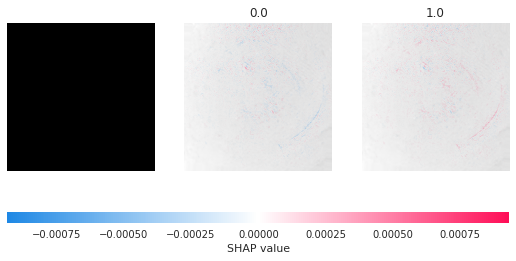

In [ ]:
# explain predictions of the model on "n_explain" images
e = shap.GradientExplainer(model, background)
shap.explainers._deep.deep_tf.op_handlers["AddV2"] = shap.explainers._deep.deep_tf.passthrough
shap_values = e.shap_values(background)

# plot the feature attributions
shap.image_plot(shap_values, -background[:n_explain], labels=lbls, hspace=0.1)

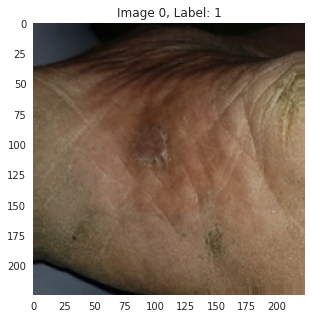

In [ ]:
n_explain = 1
valid_generator.batch_size = 10 # background dataset
background, lbls = next(valid_generator)

sns.set_style("white")
plt.figure(figsize=[5, 5])
for index, image in enumerate(background[:n_explain]):
    plt.subplot(n_explain, 1, index+1)
    plt.imshow(image)
    plt.title("Image %s, Label: %s" % (index, np.argmax(lbls[index])))

plt.show()

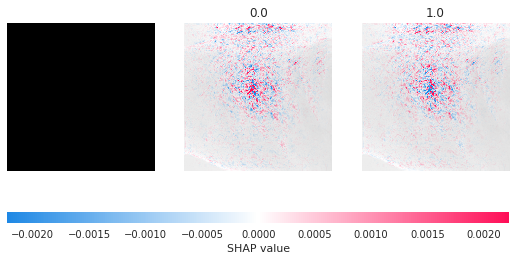

In [ ]:
# explain predictions of the model on "n_explain" images
e = shap.GradientExplainer(model, background)
shap.explainers._deep.deep_tf.op_handlers["AddV2"] = shap.explainers._deep.deep_tf.passthrough
shap_values = e.shap_values(background)

# plot the feature attributions
shap.image_plot(shap_values, -background[:n_explain], labels=lbls, hspace=0.1)

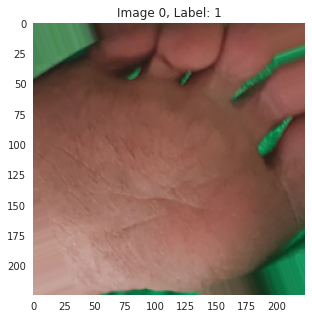

In [ ]:
n_explain = 1
valid_generator.batch_size = 10 # background dataset
background, lbls = next(valid_generator)

sns.set_style("white")
plt.figure(figsize=[5, 5])
for index, image in enumerate(background[:n_explain]):
    plt.subplot(n_explain, 1, index+1)
    plt.imshow(image)
    plt.title("Image %s, Label: %s" % (index, np.argmax(lbls[index])))

plt.show()

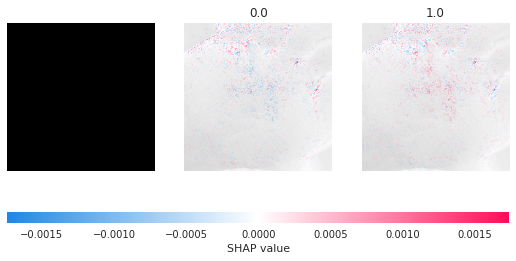

In [ ]:
# explain predictions of the model on "n_explain" images
e = shap.GradientExplainer(model, background)
shap.explainers._deep.deep_tf.op_handlers["AddV2"] = shap.explainers._deep.deep_tf.passthrough
shap_values = e.shap_values(background)

# plot the feature attributions
shap.image_plot(shap_values, -background[:n_explain], labels=lbls, hspace=0.1)

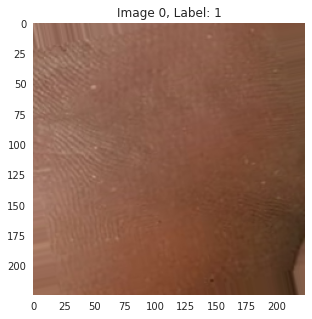

In [ ]:
n_explain = 1
valid_generator.batch_size = 10 # background dataset
background, lbls = next(valid_generator)

sns.set_style("white")
plt.figure(figsize=[5, 5])
for index, image in enumerate(background[:n_explain]):
    plt.subplot(n_explain, 1, index+1)
    plt.imshow(image)
    plt.title("Image %s, Label: %s" % (index, np.argmax(lbls[index])))

plt.show()

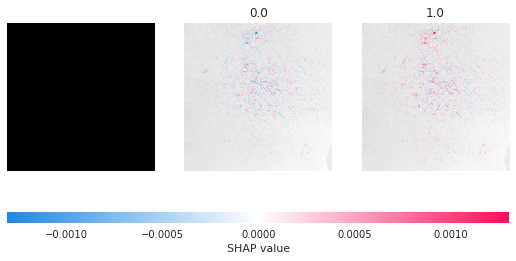

In [ ]:
# explain predictions of the model on "n_explain" images
e = shap.GradientExplainer(model, background)
shap.explainers._deep.deep_tf.op_handlers["AddV2"] = shap.explainers._deep.deep_tf.passthrough
shap_values = e.shap_values(background)

# plot the feature attributions
shap.image_plot(shap_values, -background[:n_explain], labels=lbls, hspace=0.1)